In [1]:
# Simple three-nested-loop gemm implementations in Julia, all loop orderings
function gemm_ijp!(C, A, B)
    for i in 1:size(C, 1),
         j in 1:size(C, 2),
          p in 1:size(A, 2)
        @inbounds C[i, j] += A[i, p] * B[p, j]
    end
    return C
end
function gemm_ipj!(C, A, B)
    for i in 1:size(C, 1),
         p in 1:size(A, 2),
          j in 1:size(C, 2)
        @inbounds C[i, j] += A[i, p] * B[p, j]
    end
    return C
end
function gemm_jip!(C, A, B)
    for j in 1:size(C, 2),
         i in 1:size(C, 1),
          p in 1:size(A, 2)
        @inbounds C[i, j] += A[i, p] * B[p, j]
    end
    return C
end
function gemm_jpi!(C, A, B)
    for j in 1:size(C, 2),
         p in 1:size(A, 2),
          i in 1:size(C, 1)
        @inbounds C[i, j] += A[i, p] * B[p, j]
    end
    return C
end
function gemm_pij!(C, A, B)
    for p in 1:size(A, 2),
         i in 1:size(C, 1),
          j in 1:size(C, 2)
        @inbounds C[i, j] += A[i, p] * B[p, j]
    end
    return C
end
function gemm_pji!(C, A, B)
    for p in 1:size(A, 2),
         j in 1:size(C, 2),
          i in 1:size(C, 1)
        @inbounds C[i, j] += A[i, p] * B[p, j]
    end
    return C
end

gemm_pji! (generic function with 1 method)

In [2]:
# In Julia writing code that writes code is easy,
# so here we write a little macro to generate
# the above methods for us! :)
macro def_gemm_xyz!(xyz)
    x, y, z = (Symbol(q) for q in String(xyz))

    function indexrange(q)
        if q == :i  return :(1:size(C, 1))  end
        if q == :j  return :(1:size(C, 2))  end
        if q == :p  return :(1:size(A, 2))  end
    end

    return quote
        function $(esc(Symbol(:gemm_, xyz, :!)))(C, A, B)
            for $(x) in $(indexrange(x)),
                 $(y) in $(indexrange(y)),
                  $(z) in $(indexrange(z))
                @inbounds C[i, j] += A[i, p] * B[p, j]
            end
            return C
        end
    end
end
@def_gemm_xyz! ijp
@def_gemm_xyz! ipj
@def_gemm_xyz! jip
@def_gemm_xyz! jpi
@def_gemm_xyz! pij
@def_gemm_xyz! pji

gemm_pji! (generic function with 1 method)

In [3]:
# The same definitions in C, as a string which we compile below
#
# We could programmatically generate these strings as well,
# and likewise with the wrappers below and other repeated code,
# but perhaps simple and explicit is best for now.
gemm_xyz_ccode = """
#define gamma(i,j) C[j*m + i]
#define alpha(i,p) A[p*m + i]
#define beta(p,j)  B[j*k + p]
void gemm_ijp_c(double* C, double* A, double* B, int m, int k, int n) {
    for ( int i = 0; i < m; ++i )
        for ( int j = 0; j < n; ++j )
            for ( int p = 0; p < k; ++p )
                gamma(i, j) += alpha(i, p) * beta(p, j);
}
void gemm_ipj_c(double* C, double* A, double* B, int m, int k, int n) {
    for ( int i = 0; i < m; ++i )
        for ( int p = 0; p < k; ++p )
            for ( int j = 0; j < n; ++j )
                gamma(i, j) += alpha(i, p) * beta(p, j);
}
void gemm_jip_c(double* C, double* A, double* B, int m, int k, int n) {
    for ( int j = 0; j < n; ++j )
        for ( int i = 0; i < m; ++i )
            for ( int p = 0; p < k; ++p )
                gamma(i, j) += alpha(i, p) * beta(p, j);
}
void gemm_jpi_c(double* C, double* A, double* B, int m, int k, int n) {
    for ( int j = 0; j < n; ++j )
        for ( int p = 0; p < k; ++p )
            for ( int i = 0; i < m; ++i )
                gamma(i, j) += alpha(i, p) * beta(p, j);
}
void gemm_pij_c(double* C, double* A, double* B, int m, int k, int n) {
    for ( int p = 0; p < k; ++p )
        for ( int i = 0; i < m; ++i )
            for ( int j = 0; j < n; ++j )
                gamma(i, j) += alpha(i, p) * beta(p, j);
}
void gemm_pji_c(double* C, double* A, double* B, int m, int k, int n) {
    for ( int p = 0; p < k; ++p )
        for ( int j = 0; j < n; ++j )
            for ( int i = 0; i < m; ++i )
                gamma(i, j) += alpha(i, p) * beta(p, j);
}
""";

In [4]:
# Compile!
using Libdl # standard library package
const CGemmLib = tempname()
open(`gcc -fPIC -O3 -march=native -xc -shared -o $(CGemmLib * "." * Libdl.dlext) -`, "w") do f
    print(f, gemm_xyz_ccode) 
end

In [5]:
# Wrap the C implementations as Julia functions!
gemm_ijp_c!(C::Matrix{Float64}, A::Matrix{Float64}, B::Matrix{Float64}) =
    (ccall(("gemm_ijp_c", CGemmLib), Cvoid, (Ptr{Float64}, Ptr{Float64}, Ptr{Float64}, Cint, Cint, Cint), C, A, B, size(C, 1), size(A, 2), size(C, 2)); return C)
gemm_ipj_c!(C::Matrix{Float64}, A::Matrix{Float64}, B::Matrix{Float64}) =
    (ccall(("gemm_ipj_c", CGemmLib), Cvoid, (Ptr{Float64}, Ptr{Float64}, Ptr{Float64}, Cint, Cint, Cint), C, A, B, size(C, 1), size(A, 2), size(C, 2)); return C)
gemm_jip_c!(C::Matrix{Float64}, A::Matrix{Float64}, B::Matrix{Float64}) =
    (ccall(("gemm_jip_c", CGemmLib), Cvoid, (Ptr{Float64}, Ptr{Float64}, Ptr{Float64}, Cint, Cint, Cint), C, A, B, size(C, 1), size(A, 2), size(C, 2)); return C)
gemm_jpi_c!(C::Matrix{Float64}, A::Matrix{Float64}, B::Matrix{Float64}) =
    (ccall(("gemm_jpi_c", CGemmLib), Cvoid, (Ptr{Float64}, Ptr{Float64}, Ptr{Float64}, Cint, Cint, Cint), C, A, B, size(C, 1), size(A, 2), size(C, 2)); return C)
gemm_pij_c!(C::Matrix{Float64}, A::Matrix{Float64}, B::Matrix{Float64}) =
    (ccall(("gemm_pij_c", CGemmLib), Cvoid, (Ptr{Float64}, Ptr{Float64}, Ptr{Float64}, Cint, Cint, Cint), C, A, B, size(C, 1), size(A, 2), size(C, 2)); return C)
gemm_pji_c!(C::Matrix{Float64}, A::Matrix{Float64}, B::Matrix{Float64}) =
    (ccall(("gemm_pji_c", CGemmLib), Cvoid, (Ptr{Float64}, Ptr{Float64}, Ptr{Float64}, Cint, Cint, Cint), C, A, B, size(C, 1), size(A, 2), size(C, 2)); return C)

gemm_pji_c! (generic function with 1 method)

In [6]:
# Briefly check correctness
using Test # standard library package
let
    m, n, k = 48*3, 48*2, 48
    C = rand(m, n)
    A = rand(m, k)
    B = rand(k, n)
    Cref = A * B
    @test gemm_ijp!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_ipj!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_jip!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_jpi!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_pij!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_pji!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_ijp_c!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_ipj_c!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_jip_c!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_jpi_c!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_pij_c!(fill!(C, 0), A, B) ≈ Cref
    @test gemm_pji_c!(fill!(C, 0), A, B) ≈ Cref
end

Test Passed

In [8]:
# Benchmarking time! :D
#
# We will use BenchmarkTools.jl, which makes statisically rigorous benchmarking easy.
# It's not a standard library package, so we need to use the package manager (Pkg,
# which is a standard library package, and so need not be explicitly installed)
# to install ("add") BenchmarkTools.jl prior to `using BenchmarkTools`
using Pkg; Pkg.add("BenchmarkTools")

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


In [9]:
# Now that we have BenchmarkTools.jl, we can begin with the benchmarks proper
using BenchmarkTools

# Constrain time that we allow BenchmarkTools.jl to collect samples for each benchmark
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 0.5

mnks = 48*(1:2:20)
foo = zeros(length(mnks))
timings_ijp = copy(foo)
timings_ipj = copy(foo)
timings_jip = copy(foo)
timings_jpi = copy(foo)
timings_pij = copy(foo)
timings_pji = copy(foo)
timings_ijp_c = copy(foo)
timings_ipj_c = copy(foo)
timings_jip_c = copy(foo)
timings_jpi_c = copy(foo)
timings_pij_c = copy(foo)
timings_pji_c = copy(foo)
for (mnkind, mnk) in enumerate(mnks)
    A = rand(mnk, mnk)
    B = rand(mnk, mnk)
    C = rand(mnk, mnk)
    print("Benchmarking with $mnk-by-$mnk matrices..."); @time begin
        timings_ijp[mnkind] = @belapsed gemm_ijp!($C, $A, $B)
        timings_ipj[mnkind] = @belapsed gemm_ipj!($C, $A, $B)
        timings_jip[mnkind] = @belapsed gemm_jip!($C, $A, $B)
        timings_jpi[mnkind] = @belapsed gemm_jpi!($C, $A, $B)
        timings_pij[mnkind] = @belapsed gemm_pij!($C, $A, $B)
        timings_pji[mnkind] = @belapsed gemm_pji!($C, $A, $B)
        timings_ijp_c[mnkind] = @belapsed gemm_ijp_c!($C, $A, $B)
        timings_ipj_c[mnkind] = @belapsed gemm_ipj_c!($C, $A, $B)
        timings_jip_c[mnkind] = @belapsed gemm_jip_c!($C, $A, $B)
        timings_jpi_c[mnkind] = @belapsed gemm_jpi_c!($C, $A, $B)
        timings_pij_c[mnkind] = @belapsed gemm_pij_c!($C, $A, $B)
        timings_pji_c[mnkind] = @belapsed gemm_pji_c!($C, $A, $B)
    end
end;

Benchmarking with 48-by-48 matrices... 18.042159 seconds (6.14 M allocations: 300.416 MiB, 25.94% gc time)
Benchmarking with 144-by-144 matrices... 18.939694 seconds (4.67 M allocations: 231.948 MiB, 25.05% gc time)
Benchmarking with 240-by-240 matrices... 19.253167 seconds (4.64 M allocations: 230.529 MiB, 23.41% gc time)
Benchmarking with 336-by-336 matrices... 21.535816 seconds (4.64 M allocations: 230.290 MiB, 22.29% gc time)
Benchmarking with 432-by-432 matrices... 22.547858 seconds (4.64 M allocations: 230.258 MiB, 20.34% gc time)
Benchmarking with 528-by-528 matrices... 24.346598 seconds (4.64 M allocations: 230.339 MiB, 19.22% gc time)
Benchmarking with 624-by-624 matrices... 31.795035 seconds (4.64 M allocations: 230.174 MiB, 14.98% gc time)
Benchmarking with 720-by-720 matrices... 36.274252 seconds (4.64 M allocations: 230.204 MiB, 14.30% gc time)
Benchmarking with 816-by-816 matrices... 74.278325 seconds (4.64 M allocations: 230.156 MiB, 7.03% gc time)
Benchmarking with 912-

In [10]:
# Visualize benchmarks
#
# We will use Plots.jl to visualize the benchmark results.
# Like BenchmarkTools.jl, Plots.jl is not a standard library package
# and hence we need install it prior to use:
Pkg.add("Plots")

 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]


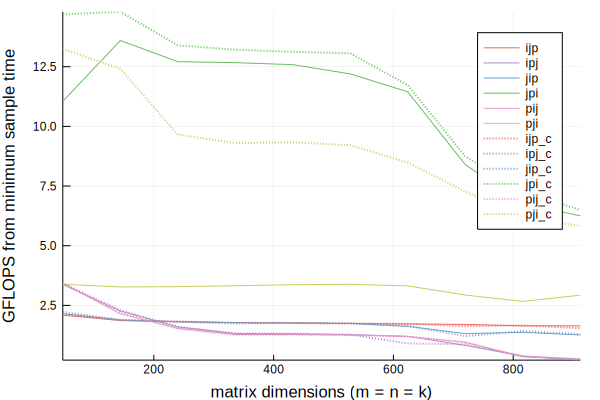

In [12]:
# Now that we have Plots.jl, we can begin with the visualizations proper
using Plots
gr() # this loads the GR framework as the drawing backend for Plots.jl

# Let's define some nice colors from the Tableau palette
tableaurgb = ((255, 158,  74), (237, 102,  93),
  (173, 139, 201), (114, 158, 206), (103, 191,  92), (237, 151, 202),
  (205, 204,  93), (168, 120, 110), (162, 162, 162), (109, 204, 218))
tableaucolors = (rgb -> string("0x", string.(rgb; base = 16, pad = 2)...)).(tableaurgb)

timetogflops(mnk, time) = 2 * mnk^3 / time / 10^9
gflops_ijp = timetogflops.(mnks, timings_ijp)
gflops_ipj = timetogflops.(mnks, timings_ipj)
gflops_jip = timetogflops.(mnks, timings_jip)
gflops_jpi = timetogflops.(mnks, timings_jpi)
gflops_pij = timetogflops.(mnks, timings_pij)
gflops_pji = timetogflops.(mnks, timings_pji)
gflops_ijp_c = timetogflops.(mnks, timings_ijp_c)
gflops_ipj_c = timetogflops.(mnks, timings_ipj_c)
gflops_jip_c = timetogflops.(mnks, timings_jip_c)
gflops_jpi_c = timetogflops.(mnks, timings_jpi_c)
gflops_pij_c = timetogflops.(mnks, timings_pij_c)
gflops_pji_c = timetogflops.(mnks, timings_pji_c)

ylims = extrema(vcat(
        gflops_ijp, gflops_ipj,
        gflops_jip, gflops_jpi,
        gflops_pij, gflops_pji,
        gflops_ijp_c, gflops_ipj_c,
        gflops_jip_c, gflops_jpi_c,
        gflops_pij_c, gflops_pji_c))
foo = plot(mnks, gflops_ijp, label = "ijp", color = tableaucolors[2],
  xlabel = "matrix dimensions (m = n = k)",
  ylabel = "GFLOPS from minimum sample time",
  xlim = (first(mnks), last(mnks)),
  ylim = (first(ylims), last(ylims)),)
plot!(mnks, gflops_ipj, label = "ipj", color = tableaucolors[3])
plot!(mnks, gflops_jip, label = "jip", color = tableaucolors[4])
plot!(mnks, gflops_jpi, label = "jpi", color = tableaucolors[5])
plot!(mnks, gflops_pij, label = "pij", color = tableaucolors[6])
plot!(mnks, gflops_pji, label = "pji", color = tableaucolors[7])
plot!(mnks, gflops_ijp_c, label = "ijp_c", line = (2, :dot), color = tableaucolors[2])
plot!(mnks, gflops_ipj_c, label = "ipj_c", line = (2, :dot), color = tableaucolors[3])
plot!(mnks, gflops_jip_c, label = "jip_c", line = (2, :dot), color = tableaucolors[4])
plot!(mnks, gflops_jpi_c, label = "jpi_c", line = (2, :dot), color = tableaucolors[5])
plot!(mnks, gflops_pij_c, label = "pij_c", line = (2, :dot), color = tableaucolors[6])
plot!(mnks, gflops_pji_c, label = "pji_c", line = (2, :dot), color = tableaucolors[7])